In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import os
os.environ['CUDA_VISIBLE_DEVICES']= '0'

In [2]:
DATA_DIR = '/home/user/Desktop/airbus-ship-detection'

# Directory to save logs and trained model
ROOT_DIR = '/home/user/Desktop/working/ng'

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [4]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [3]:
train_dicom_dir = os.path.join(DATA_DIR, 'train')
test_dicom_dir = os.path.join(DATA_DIR, 'test')

In [6]:

!ls -lh mask_rcnn_coco.h5
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-rw-r-- 1 user user 246M 十二 14 16:17 mask_rcnn_coco.h5


In [7]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and ship classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.0

    STEPS_PER_EPOCH = 15 if __debug__ else 150
    VALIDATION_STEPS = 10 if __debug__ else 125
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     9
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 9
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [5]:
from PIL import Image
from sklearn.model_selection import train_test_split

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(train_dicom_dir) if f not in exclude_list]
test_names = [f for f in os.listdir(test_dicom_dir) if f not in exclude_list]

print(len(train_names), len(test_names))


104069 88486


In [10]:
# training dataset
SEGMENTATION = DATA_DIR + '/train_ship_segmentations.csv'
anns = pd.read_csv(SEGMENTATION)
anns.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [11]:
train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist()  ## override with ships

test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU
image_fps_train, image_fps_val = train_test_split(train_names, test_size=test_size, random_state=42)

if __debug__:
    image_fps_train = image_fps_train[:100]
    image_fps_val = image_fps_val[:100]
    test_names = test_names[:100]
    
print(len(image_fps_train), len(image_fps_val), len(test_names))

100 90 100


In [12]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('ship', 1, 'Ship')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dicom_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [13]:
image_fps, image_annotations = train_names, anns
len(image_fps)

29070

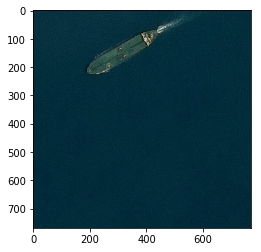

In [14]:
ds = imread(os.path.join(train_dicom_dir, image_fps[29069])) # read  image from filepath 
_ = plt.imshow(ds)
#for i in range(0,1,29070):
#    ds = imread(os.path.join(train_dicom_dir, image_fps[i])) # read  image from filepath 
#    _ = plt.imshow(ds)

In [15]:
# Original image size: 768 x 768
ORIG_SIZE = ds.shape[0]
ORIG_SIZE

768

In [16]:
%%time
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

CPU times: user 397 ms, sys: 15.8 ms, total: 412 ms
Wall time: 385 ms


In [1]:
%%time
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

NameError: name 'DetectorDataset' is not defined

(768, 768, 3)
/home/user/Desktop/airbus-ship-detection/train/6d6468e24.jpg
[1 1 1 1 1 1 1 1 1 1 1 1]


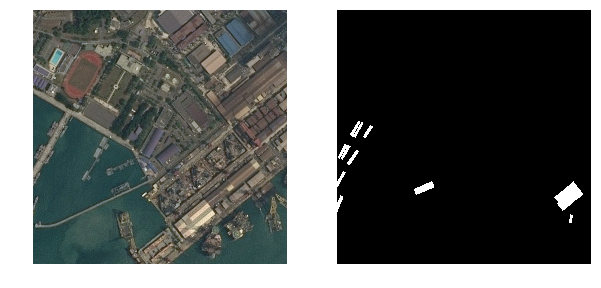

In [88]:
#class_ids = [0]
#while class_ids[0] == 0:  ## look for a mask
#    for i in range(28980):
#        image_id = i
#        image_fp = dataset_train.image_reference(image_id)
#        image = dataset_train.load_image(image_id)
#        mask, class_ids = dataset_train.load_mask(image_id)
#        cv2.imwrite('/home/user/A/%s.jpg' %(i), image)
#        masked = np.zeros(image.shape[:2])
#        for k in range(mask.shape[2]):
#            masked += mask[:, :, k] 
#        cv2.imwrite('/home/user/AA/%s.jpg' %(i), masked.astype('uint8') * 255)

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    image_fp = dataset_val.image_reference(image_id)
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    
print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += mask[:, :, i] ## * image[:, :, 0]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

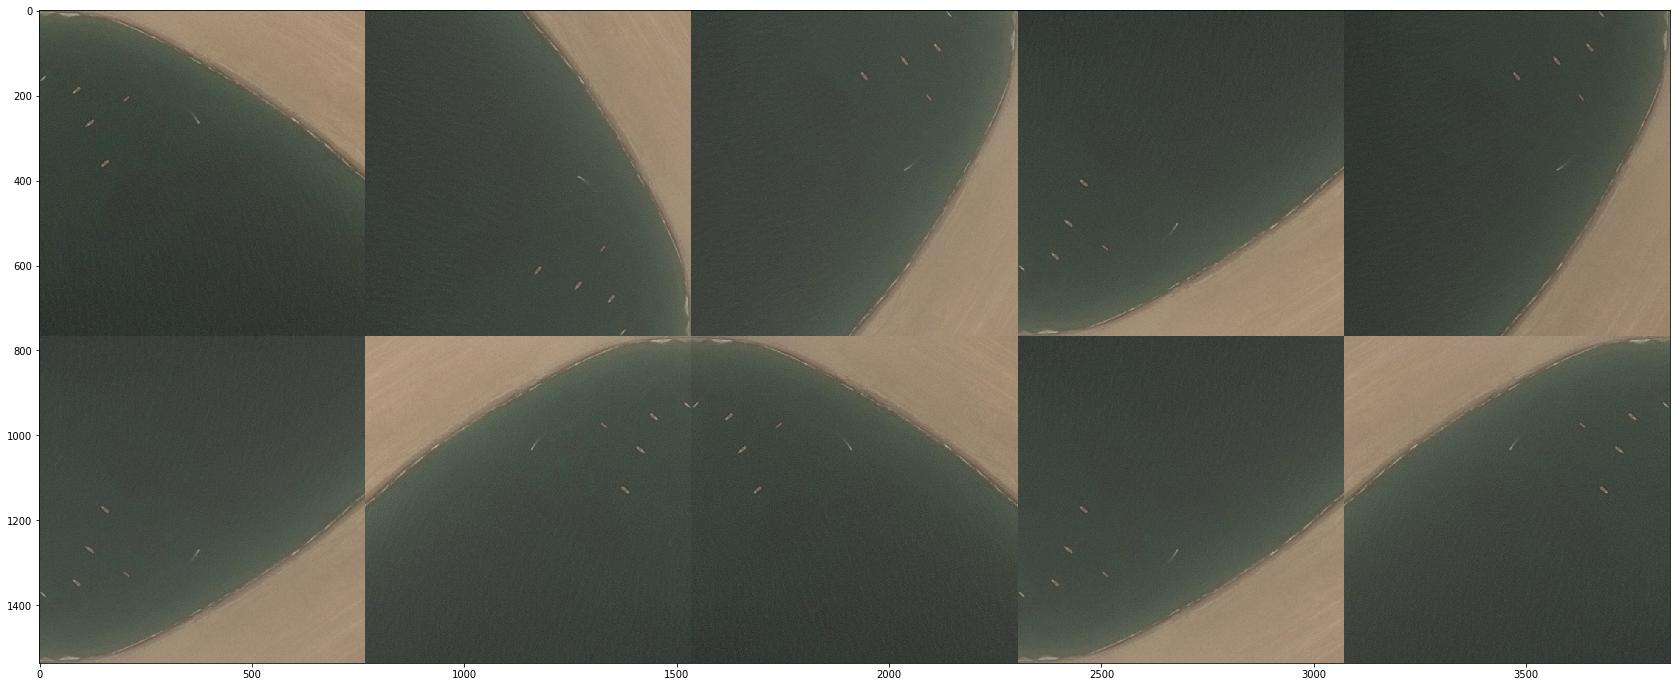

In [70]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid.astype(int))

In [20]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [21]:
LEARNING_RATE = 0.003

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [22]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=5,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: /home/user/Desktop/working/ng/airbus20190106T2009/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_m

In [23]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=25,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 5. LR=0.003

Checkpoint Path: /home/user/Desktop/working/ng/airbus20190106T2009/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_br

In [24]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=50,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 25. LR=0.0015

Checkpoint Path: /home/user/Desktop/working/ng/airbus20190106T2009/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_

In [25]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,3.328328,0.675373,0.735423,0.699647,0.709631,0.508253,4.313141,1.190952,0.743330,1.363960,0.496367,0.518530
2,3.299489,0.617467,0.967788,0.482137,0.821785,0.410310,1.976534,0.358502,0.667528,0.195764,0.389501,0.365237
3,2.656175,0.413385,0.822606,0.221219,0.753249,0.445714,2.445767,0.631729,0.940232,0.143692,0.343200,0.386914
4,2.253425,0.421087,0.699724,0.109006,0.494966,0.528641,2.133725,0.486789,0.597973,0.220797,0.373010,0.455155
5,3.075713,0.407962,1.060708,0.226770,0.785400,0.594871,1.676859,0.185605,0.458294,0.119117,0.396383,0.517458
6,3.179454,0.443731,0.875380,0.548558,0.761022,0.550756,2.062502,0.157358,0.739045,0.329884,0.397499,0.438710
7,2.731614,0.495277,0.859841,0.376291,0.540694,0.459503,1.454041,0.078955,0.491503,0.192755,0.339109,0.351713
8,2.058826,0.309657,0.737477,0.201117,0.378176,0.432392,2.574479,0.627964,1.165973,0.156358,0.310295,0.313882
9,1.722028,0.225036,0.620535,0.094663,0.382896,0.398891,1.931208,0.353211,0.577346,0.179805,0.335167,0.485673
10,2.086109,0.365532,0.746765,0.148569,0.360563,0.464674,1.172846,0.069698,0.359438,0.073633,0.242126,0.427946


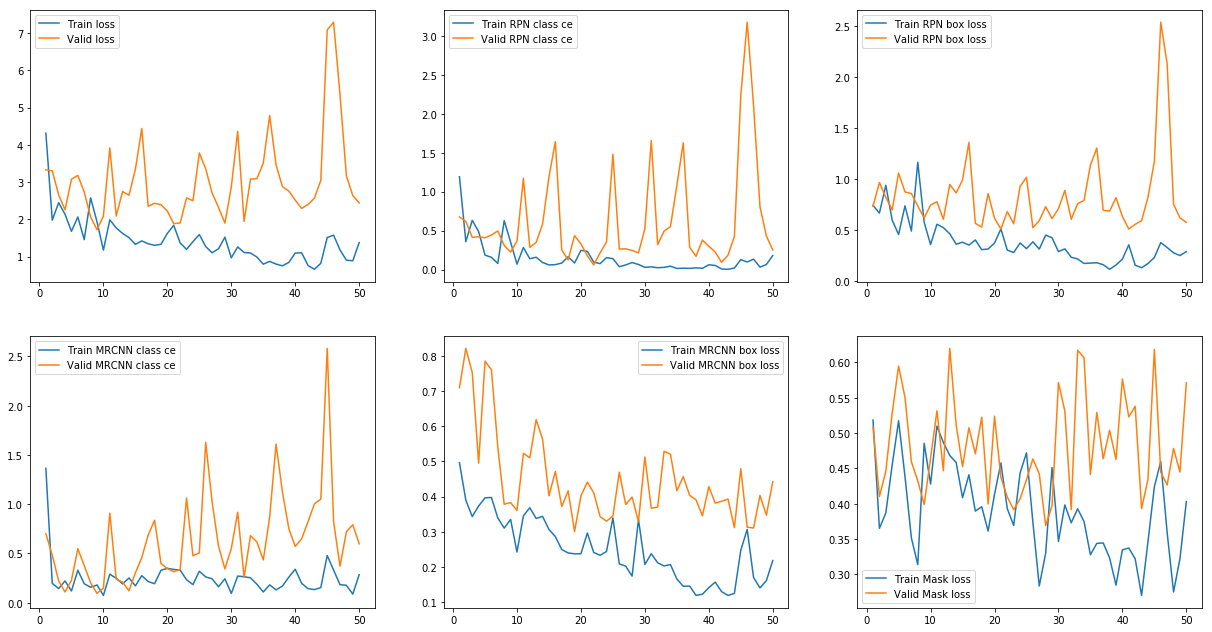

In [26]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [27]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /home/user/Desktop/working/ng/airbus20190106T2009/mask_rcnn_airbus_0002.h5


In [28]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/user/Desktop/working/ng/airbus20190106T2009/mask_rcnn_airbus_0002.h5
Re-starting from epoch 2


In [29]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

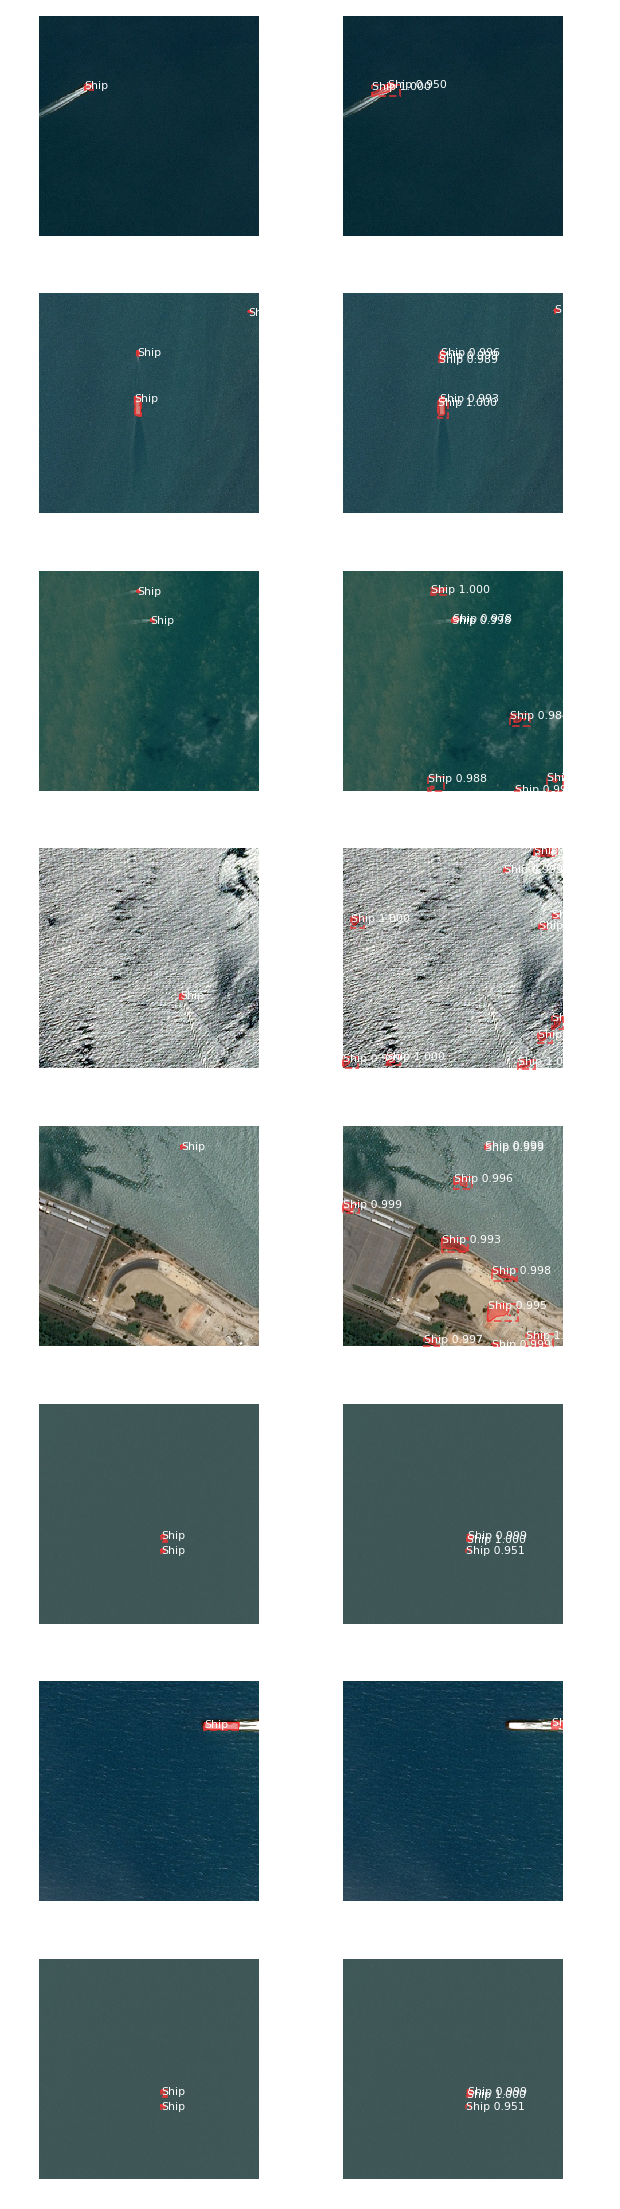

In [32]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [31]:
# Get filenames of test dataset images
test_image_fps = test_names

In [ ]:
DETECTION_TEST_PRED = '/home/user/Desktop/fine-tuning-resnet34-on-ship-detection-new-data/ship_detection.csv'
ship_detection = pd.read_csv(DETECTION_TEST_PRED, index_col='id')
ship_detection.head()

In [ ]:
THRESHOLD = 0.45
test_names_nothing = ship_detection.loc[ship_detection['p_ship'] <= THRESHOLD].index.tolist()
len(test_names_nothing), len(ship_detection), len(test_names_nothing)/len(ship_detection)

In [ ]:
def predict(image_fps, filepath='submission.csv', min_conf=config.DETECTION_MIN_CONFIDENCE):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("ImageId,EncodedPixels\n")

        for image_id in tqdm(image_fps):
            found = False
            
            if image_id not in test_names_nothing:
                image = imread(os.path.join(test_dicom_dir, image_id))
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
#                 image, window, scale, padding, crop = utils.resize_image(
#                     image,
#                     min_dim=config.IMAGE_MIN_DIM,
#                     min_scale=config.IMAGE_MIN_SCALE,
#                     max_dim=config.IMAGE_MAX_DIM,
#                     mode=config.IMAGE_RESIZE_MODE)

                results = model.detect([image])
                r = results[0]

                assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                if len(r['rois']) == 0:
                    pass  ## no ship
                else:
                    num_instances = len(r['rois'])

                    for i in range(num_instances):
                        if r['scores'][i] > min_conf:
#                             print(r['scores'][i], r['rois'][i], r['masks'].shape, np.sum(r['masks'][...,i]))
#                             plt.imshow(r['masks'][...,i], cmap=get_cmap('jet'))
                            file.write(image_id + "," + rle_encode(r['masks'][...,i]) + "\n")
                            found = True

            if not found:
                file.write(image_id + ",\n")  ## no ship

In [ ]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

In [ ]:
sub = pd.read_csv(submission_fp)
print(sub.EncodedPixels.isnull().sum(), sub.ImageId.nunique(), sub.EncodedPixels.isnull().sum()/sub.ImageId.nunique())
sub.head(50)

In [ ]:
# show a few test image detection example
def visualize_test(): 
    image_id = random.choice(test_names)
    
    # original image
#     print(image_id)
    image = imread(os.path.join(test_dicom_dir, image_id))
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
#     image, window, scale, padding, crop = utils.resize_image(
#         image,
#         min_dim=config.IMAGE_MIN_DIM,
#         min_scale=config.IMAGE_MIN_SCALE,
#         max_dim=config.IMAGE_MAX_DIM,
#         mode=config.IMAGE_RESIZE_MODE)

    results = model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
#         print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title(f"{image_id}")
    ax1.imshow(image)
    ax2.set_title(f"{len(r['rois'])} masks if prob:{ship_detection.loc[image_id][0]:.6f}")
    ax2.imshow(masks_as_color(sub.query(f"ImageId=='{image_id}'")['EncodedPixels']))

for i in range(8):
    visualize_test()